# Image Classification with Deep Learning Project
***

**Author:** Ron Lodetti Jr.
![Heart](./images/heart.jpeg)

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

In [81]:
%load_ext autoreload
%autoreload 2
from my_modules import data_understanding, data_prep, data_modeling, data_modeling2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import pandas as pd
import tensorflow as tf
import numpy as np
import random

# Set the random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Understanding
The dataset originally comes from Kermany et al. on [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3). I downloaded the data from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) as it had already separated out the chest x-ray images from other data in the original dataset.

The following description is taken directly from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia):
>The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
>
>Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
>
>For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.


Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.

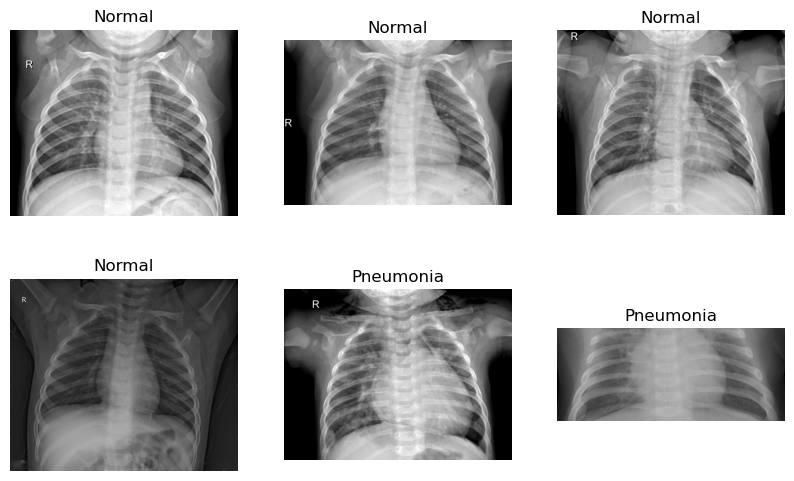

In [3]:
# Displaying 6 random raw images.

normal_dir = 'data/chest_xray/train/NORMAL/'
pneumonia_dir = 'data/chest_xray/train/PNEUMONIA/'

data_understanding.show_images(normal_dir,pneumonia_dir)

I noticed that the images have different dimensions. During data prep, I'll be sure to standardize the aspect ratio as I don't want my model to make any predictions based on the aspect ratio of the image. 

In [11]:
# Here is a function which counts the number of images in each directory and outputs a dataframe.
data_dir = 'data/chest_xray'
folders = ['train', 'val', 'test']
df = data_understanding.prepare_plot(data_dir,folders)
df

,Dataset,Normal,Pneumonia,Total
0,train,1341,3875,5216
1,val,8,8,16
2,test,234,390,624


I notice that there are only 16 total images in the validation set. Also, the ratio of Positive (Pneumonia) to Negative images aren't consistent betwen train, validation, and test datasets. 

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### Redistribute Data
The first thing I will do is to redistribute the data, giving an 80-10-10 train-validation-test split. I also made sure to keep the positive/negative ratio the same for each dataset. 

In [12]:
# Run the run_redistribution function from the data_prep module
# data_prep.run_redistribution()

In [13]:
# Displaying a dataframe of the counts of the redistributed data
new_folders = ['new_train', 'new_val', 'new_test']
new_df = data_understanding.prepare_plot(data_dir,new_folders)
new_df

,Dataset,Normal,Pneumonia,Total
0,new_train,1266,3418,4684
1,new_val,158,427,585
2,new_test,159,428,587


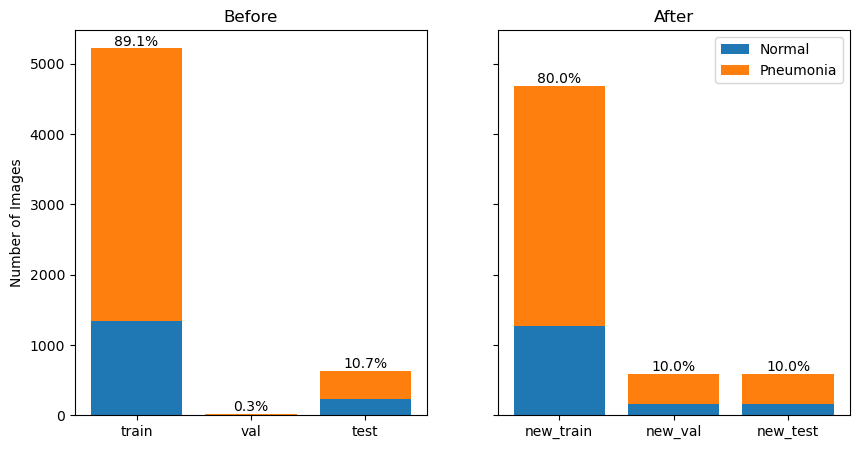

In [15]:
# Displaying the distribution of the datasets before and after redistribution
data_prep.compare_bar(df, new_df)

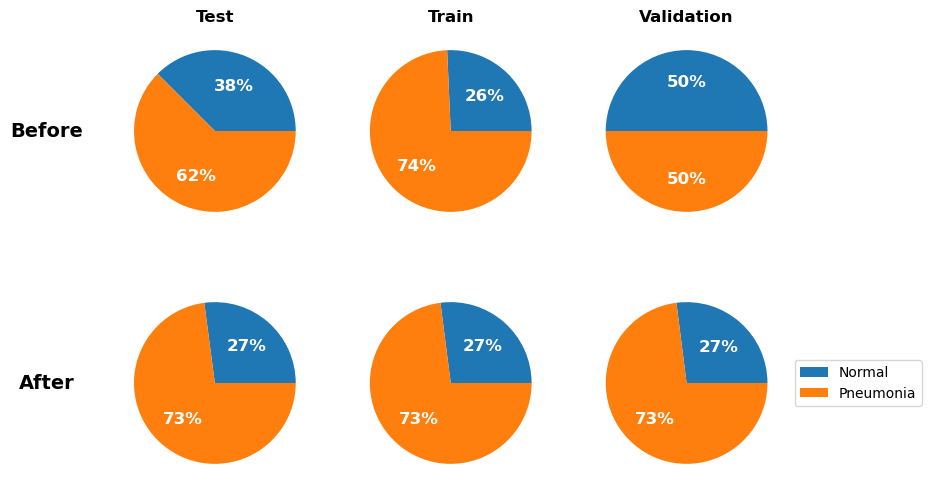

In [16]:
# Displaying the positive/negative ratio for each dataset before and after redistribution
data_prep.pie(df, new_df)

Now that we have an 80-10-10 stratified split, I want to normalize the aspect ratio of the images. 

In [17]:
# Combining the widths and heights of training and validation to find image size statistics.
# Note that the test set is not included here to avoid data leakage. 
train_dir = 'data/chest_xray/new_train'
val_dir = 'data/chest_xray/new_val'

train_widths, train_heights = data_prep.get_image_sizes(train_dir)
val_widths, val_heights = data_prep.get_image_sizes(val_dir)

widths = np.concatenate((train_widths, val_widths))
heights = np.concatenate((train_heights, val_heights))

AVG_RATIO = data_prep.print_image_statistics(widths, heights)

Number of images: 5269
Average width: 1327
Average height: 969
Average aspect ratio: 1.3686277519996741
Max width: 2916
Max height: 2713
Min width: 384
Min height: 127


###  Create Dataset
Since the average aspect ratio is about 1.37, I'll crop my images to that ratio when importing without distoring the image itself. Given that the important information is likely in the center of the image, cropping edges of the images likely would not impact the classification. 

In [19]:
def create_dataset(directory, ratio=AVG_RATIO, process=False, is_training=True):
    """
    Creates a dataset from a directory of images, resizing them to a consistent size.

    Parameters:
    - directory: Path to the directory where the image files are located.
    - ratio: Aspect ratio to determine the width of the images based on a fixed height.
    - process: Whether or not to apply additional data processing.
    - is_training: To differntiate between training, validation, and testing sets.

    Returns:
    A tf.data.Dataset object.
    """
    height = 64 # Size chosen based on processing resources
    width = int(height * ratio) # setting the width to ensure average aspect ratio
    dataset = image_dataset_from_directory(
        directory,
        label_mode='binary', # There are two labels, 'Normal' or 'Pneumonia'
        color_mode="grayscale", # Original images are in grayscale, specifying to ensure dimension reduction
        batch_size=32, # selected  based on processing resources
        image_size=(height, width),
        shuffle=is_training,  # Shuffle only if it's the training dataset
        crop_to_aspect_ratio=True,
        seed=42
    )
    if process:
        return process_dataset(dataset) # Applying any additional processing steps if necessary
    else:
        return dataset

In [20]:
preprocessed_train_ds = data_prep.create_dataset(train_dir, ratio=AVG_RATIO, process=False, is_training=True)

Found 4684 files belonging to 2 classes.


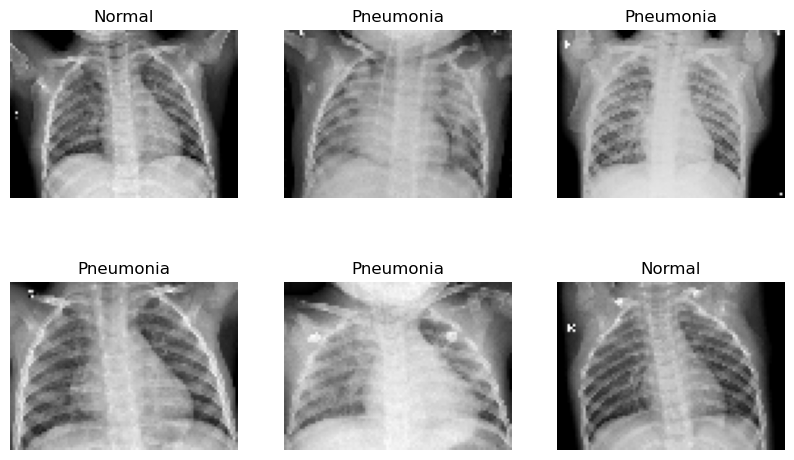

In [21]:
# Displaying images after importing
data_prep.show_images(preprocessed_train_ds)

Images are a consistent aspect ratio and appear to still include imnportant information. They are also noticably grainer, which could affect the future model's prediction abilities. 

In [41]:
# Inspecting an imported image
for inputs, labels in preprocessed_train_ds.take(1):
        image_tensor = inputs[0]
        print(image_tensor)

tf.Tensor(
[[[122.66258 ]
  [117.0466  ]
  [110.08692 ]
  ...
  [ 84.23406 ]
  [ 89.82017 ]
  [ 97.04013 ]]

 [[117.47872 ]
  [107.86584 ]
  [118.7399  ]
  ...
  [ 94.13681 ]
  [ 96.87364 ]
  [ 99.07554 ]]

 [[113.61238 ]
  [140.65207 ]
  [142.57974 ]
  ...
  [ 88.55069 ]
  [ 88.28624 ]
  [ 86.730316]]

 ...

 [[214.      ]
  [213.34012 ]
  [214.99686 ]
  ...
  [211.66406 ]
  [212.53085 ]
  [213.61966 ]]

 [[214.      ]
  [214.95111 ]
  [217.      ]
  ...
  [208.      ]
  [210.60156 ]
  [212.46939 ]]

 [[214.      ]
  [212.51912 ]
  [212.79373 ]
  ...
  [208.86719 ]
  [209.13281 ]
  [210.13281 ]]], shape=(64, 87, 1), dtype=float32)


Let's rescale the tensor for computational efficiency

In [42]:
def process_dataset(dataset, is_training=True):
    """
    Processes the dataset by rescaling, (optionally shuffling for validation/test), caching, and prefetching.

    Parameters:
    - dataset: A tf.data.Dataset object to process.
    - is_training: To differntiate between training, validation, and testing sets.

    Returns:
    A processed tf.data.Dataset object.
    """
    # Normalizing the dataset by rescaling
    rescale = Rescaling(1./255)
    dataset = dataset.map(lambda x, y: (rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        # Shuffle only if it's the training dataset
        dataset = dataset.shuffle(buffer_size=1000, seed=42)

    # Cache the dataset to improve performance
    dataset = dataset.cache()

    # Prefetch to optimize loading
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [43]:
train_ds = process_dataset(preprocessed_train_ds, is_training=True)
for inputs, labels in train_ds.take(1):
        image_tensor = inputs[0]
        print(image_tensor)

tf.Tensor(
[[[0.14199029]
  [0.18361859]
  [0.25463364]
  ...
  [0.14038543]
  [0.        ]
  [0.        ]]

 [[0.12764186]
  [0.19800648]
  [0.24144447]
  ...
  [0.10263945]
  [0.        ]
  [0.        ]]

 [[0.12249903]
  [0.19211672]
  [0.24569954]
  ...
  [0.09123775]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]], shape=(64, 87, 1), dtype=float32)


The tensor is scaled. Let's see if this affected the images.

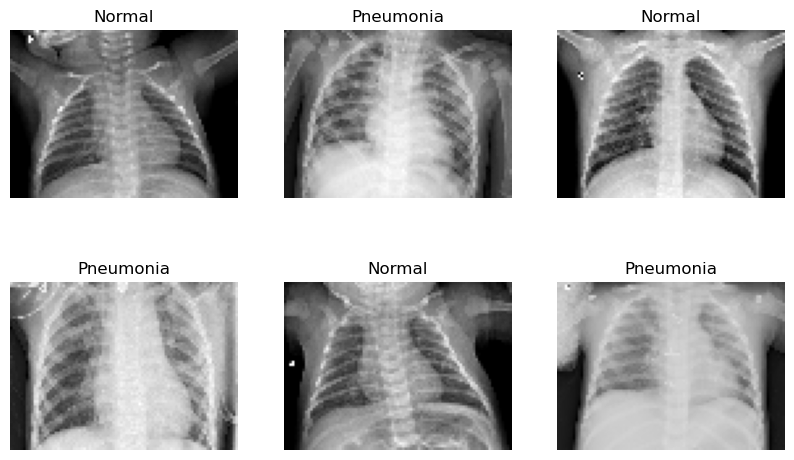

In [44]:
# Displaying processed images
data_prep.show_images(train_ds)

The images are still the correct aspect ratio and possibly grainier, although scaling should reduce any actual data. 

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

Questions to consider:

How did you analyze or model the data?
How did you iterate on your initial approach to make it better?
Why are these choices appropriate given the data and the business problem?

I will be using the validation dataset to score any model trained to see how it does on unseen data.

In [46]:
# Create and process validation set
val_ds = data_prep.create_dataset(val_dir, ratio=AVG_RATIO, process=True, is_training=False)

# Calculating input shape to be fed into model
for inputs, labels in train_ds.take(1):
        input_shape = inputs.shape[1:]
        break
print(f'Input Shape:{input_shape}')

Found 585 files belonging to 2 classes.
Input Shape:(64, 87, 1)


For metrics, I chose Recall to emphasise the importance of minimizing false negatives, aka identifyijng a sick patient as healthy. I also included the Area under the ROC to give insight into the model's overall performance and to guard against merely labeling all cases as positive to achieve a high recall.

In [48]:
METRICS = [
    Recall(name='recall'),
    AUC(name='auc')]

In [85]:
# Creating a function to predict and plot a confusion matrix
def con_mat(model, dataset):
    images_list = []
    labels_list = []
    
    # Iterate over the test dataset
    for images, labels in dataset:
        # Convert the current batch to numpy and append it to the lists
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    
    # Concatenate all batches to create single arrays
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
                                 
    y_preds = (model.predict(images) >= 0.5).astype(int)
    y_test = labels

    cnf_matrix = confusion_matrix(y_test,y_preds,normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
    disp.plot()
    plt.show()

### Baseline Model
For my baseline model I decided to use a simple neural network with no hidden layers. 

Training time: 8.66229796409607 seconds



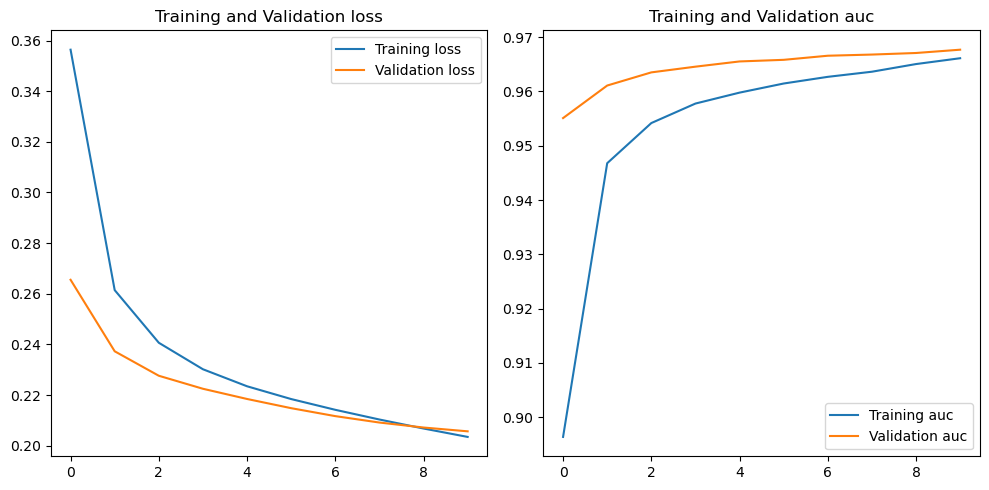

           loss    recall       auc
Train  0.198611  0.916325  0.974479
Val    0.205656  0.939110  0.967695
Diff   0.007045  0.022785 -0.006784
------------------------------



In [57]:
baseline_model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(1, activation='sigmoid')]) # using sigmoid activation and one node in my output layer for binary classification

# Choosing the 'Adam' optimizer for efficiencty.
# Choosing 'binary_crossentropy' as loss function given bineary classification. 
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)


# results = baseline_model.fit(train_ds, epochs=10, validation_data=val_ds)

data_modeling2.modeler(baseline_model, train=train_ds, val=val_ds, metrics=METRICS,
            optimizer='adam', num_epochs=10)

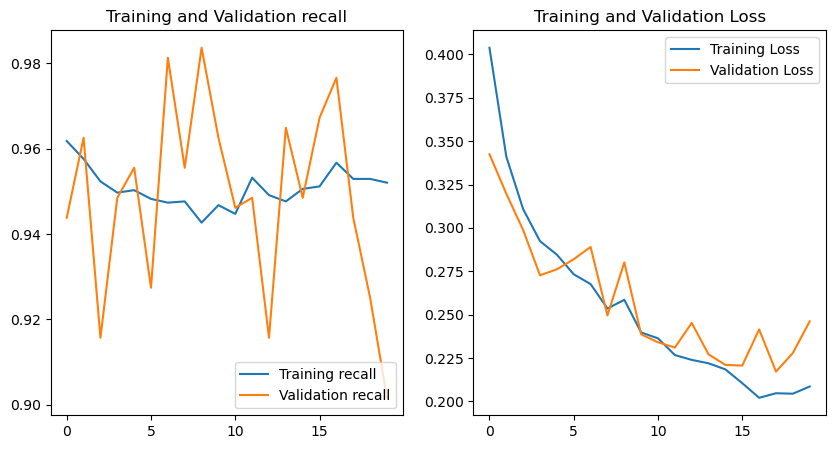

,loss,recall,AUC
baseline,0.2461,0.9016,0.9565


In [90]:
baseline_model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')]) # using sigmoid activation and one node in my output layer for binary classification

# Choosing the 'Adam' optimizer for efficiencty.
# Choosing 'binary_crossentropy' as loss function given bineary classification. 
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# loading model instead of running.
# results = model.fit(train_ds, epochs=20, validation_data=val_ds)

baseline_model = data_modeling.summary_viz('baseline', val_ds)

19/19 [==============================] - 0s 2ms/step


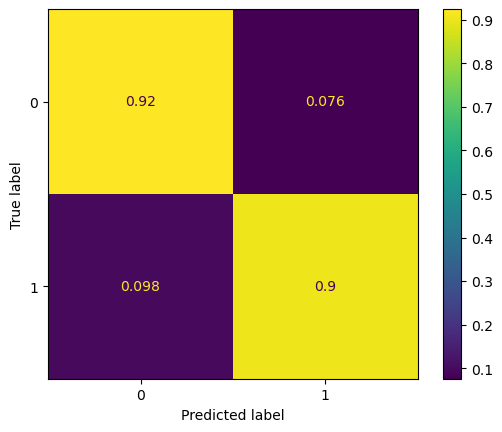

In [91]:
con_mat(baseline_model, val_ds)

According to the confusion matrix, it correctly labeled 92% of the negative cases and 90% of the positive cases. 
The baseline mislabeled 9.8% of sick patients as healthy and 7.6% of healthy patients as sick. My goal is to reduce that 9.8% (or recall) as much as possible. 


### Initializers
After my simple baseline model I decided to experiment with different initializers to help my model start off from a better position, which can lead to faster convergence and potentially better overall performance.

In [51]:
# Loading models to save time
file_names = ['model_I1','model_I2']
model_names = ['he_normal', 'lecun_normal']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
he_normal,0.2118,0.9508,0.9622
lecun_normal,0.2128,0.9696,0.9638


Given the similarity in results, I decided to go with 'he_normal' as it is generally recommended for layers with 'relu' activation. I'll be sure to test this again later. 

### Building Complex Model
At this point I decided to add layers and nodes to my model to help it to see any patterns that may exist, even at the risk of over fitting the data. 

I began by adding more nodes and dense layers. Then I built a Convolution Neural Network, adding layers and nodes until I reached a complex enough model and noticed overfitting.  

In [52]:
file_names = ['model_2','model_3','model_5','model_6','model_7']
model_names = ['Dense: more nodes','Dense: 3 layers','Conv: 1 layer','Conv: 2 layers','Conv: 3 layers']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
Dense: more nodes,0.2243,0.9766,0.9690
Dense: 3 layers,0.1829,0.9602,0.9727
Conv: 1 layer,0.2505,0.9766,0.9735
Conv: 2 layers,0.3926,0.9696,0.9661
Conv: 3 layers,0.3567,0.9813,0.9703


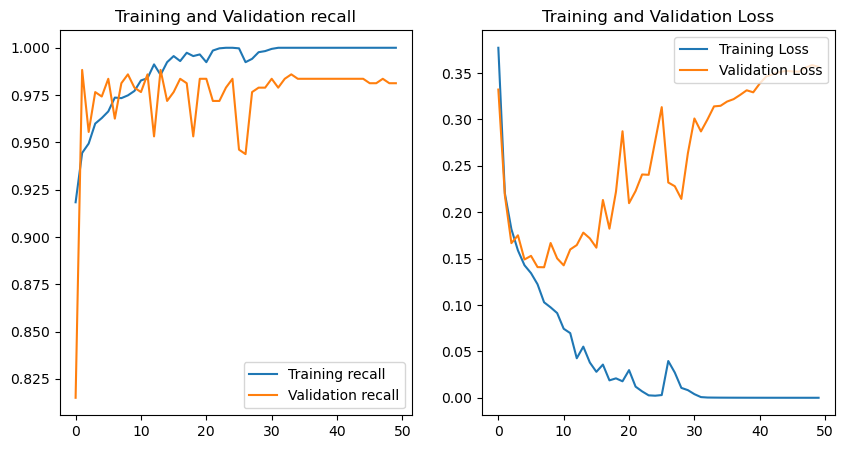

,loss,recall,AUC
model_7,0.3567,0.9813,0.9703


In [92]:
overfit_model = Sequential([
    Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', input_shape= input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu',kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

overfit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# loading model instead of running.
# results = overfit_model.fit(train_ds, epochs=20, validation_data=val_ds)
overfit_model = data_modeling.summary_viz('model_7', val_ds)

19/19 [==============================] - 1s 33ms/step


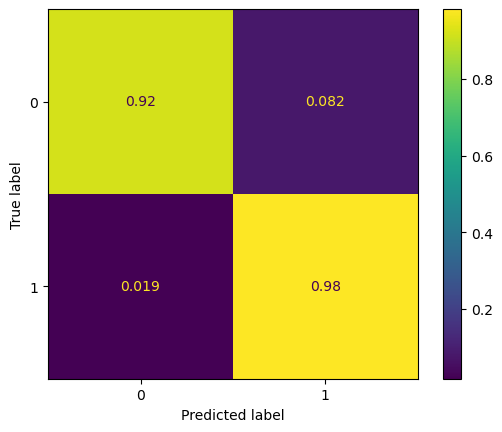

In [93]:
con_mat(overfit_model, val_ds)

The overfit model mislabeled 1.9% of sick patients as healthy a pretty significant increase from our baseline of 9.8%.

147/147 [==============================] - 4s 30ms/step


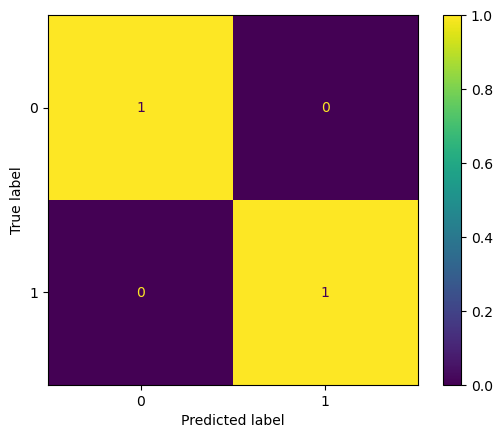

In [94]:
con_mat(overfit_model, train_ds)

And, of course, perfectly predicts the training data.

### Optimizers
Now that I added complexity to my model I began experimenting with optimizers to see how they affect how quickly and effectively the model learns. I began using early stopping here stop the model from training after it doesn't see significant improvement in the validation loss metric. 

In [59]:
early_stopping = EarlyStopping(monitor='val_loss', # metric to monitor for improvment. 
                               min_delta=0.001, # minimum improvement.
                               patience=10, # how long it will wait to see improvment
                               mode='min', 
                               restore_best_weights=True, # after 10 epochs without improvement, it will restore the model with the best weights. 
                               verbose=1)

After evaluating Adam, RMSprop, and SGD optimizers using their default learning rates, I selected the SGD optimizer. This decision was based on its superior ability to quickly learn from the training data. Further experimentation with various learning rates [0.1, 0.01, 0.001] and momentum values [0, 0.5, 0.9, 0.99] led me to choose a learning rate of 0.01 and a momentum of 0.9 for SGD. This configuration achieved the fastest convergence and the lowest validation loss. Notably, it maintained training stability, unlike the higher momentum value of 0.99, which resulted in unstable training.

In [61]:
file_names = ['model_O1','model_O2','model_O3','model_O4','model_O5','model_O6','model_O7','model_O8','model_O9']
model_names = ['model_O1','model_O2','model_O3','model_O4','model_O5','model_O6','model_O7','model_O8','model_O9']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
model_O1,0.1231,0.9766,0.9851
model_O2,0.1226,0.9719,0.9840
model_O3,0.1328,0.9719,0.9833
model_O4,0.1229,0.9696,0.9857
model_O5,0.1237,0.9602,0.9884
model_O6,0.1411,0.9789,0.9831
model_O7,0.1305,0.9696,0.9853
model_O8,0.1131,0.9578,0.9879
model_O9,0.2365,0.9251,0.9596


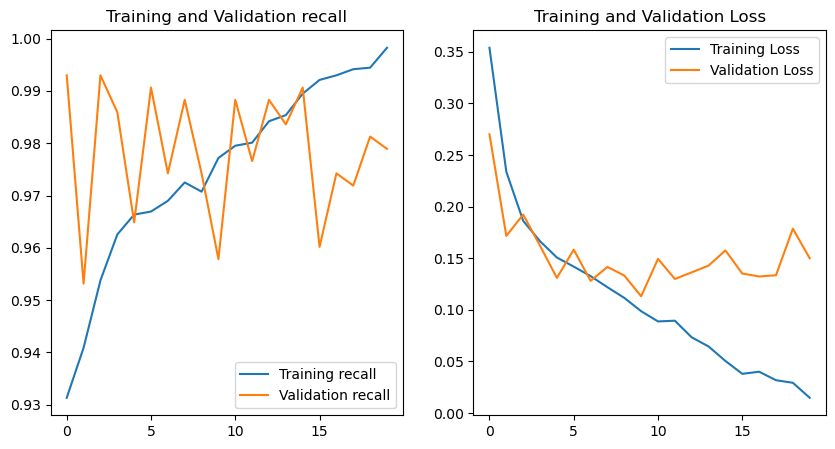

,loss,recall,AUC
model_O8,0.1131,0.9578,0.9879


In [62]:
data_modeling.summary_viz('model_O8', val_ds)

### Regularization
Since I have a model that is overfitting, I applied regularization methods, such as dropout, L1/L2 regularization, and data augmentation, help in making the model less sensitive to the specific details of the training data, encouraging it to learn more generalized patterns that apply to unseen data as well.

#### Dropout Layers
After experimenting with the placement of dropout layers and adjusting their rates, I determined the optimal configuration for my model involves situating dropout layers immediately following the Conv2D layers and one before the output layer, applying a dropout rate of 0.25. This arrangement effectively prevents overfitting by introducing regularization right after feature extraction in the convolutional layers and prior to the final classification, enhancing the model's ability to generalize from the training data.

In [63]:
file_names = ['model_R1','model_R2','model_R3','model_R4','model_R5','model_R6']
model_names = ['After MaxPooling','After Conv','After Dense','After Max and Dense','After Conv and Dense','After Conv and Dense with 0.5']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
After MaxPooling,0.1122,0.9578,0.9915
After Conv,0.1062,0.9883,0.9911
After Dense,0.1132,0.9836,0.9858
After Max and Dense,0.1113,0.9719,0.9910
After Conv and Dense,0.0901,0.9836,0.9933
After Conv and Dense with 0.5,0.1422,0.9766,0.9893


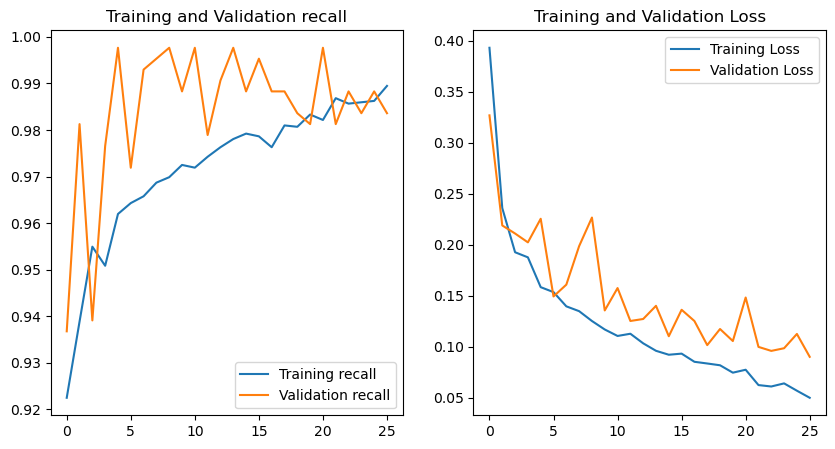

,loss,recall,AUC
model_R5,0.0901,0.9836,0.9933


In [95]:
# Dropout layers after Conv2D and Dense layers
dropout_model = Sequential([
    Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', input_shape= input_shape),
    Dropout(0.25),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    Dropout(0.25),    
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'),
    Dropout(0.25),    
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu',kernel_initializer='he_normal'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), 
                      loss='binary_crossentropy', 
                      metrics=METRICS)

# loading model instead of running.
# dropout_results = dropout_model.fit(train_ds, epochs=50, validation_data=val_ds, 
#                                     early_stopping= early_stopping)

dropout_model = data_modeling.summary_viz('model_R5', val_ds, early_stopping=True)

19/19 [==============================] - 1s 29ms/step


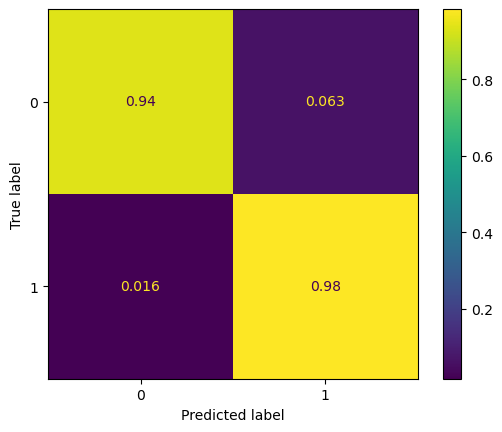

In [97]:
con_mat(dropout_model, val_ds)

#### L1/L2 Regularization
L2 clearly outperformed L1 regularization.

In [66]:
file_names = ['model_R7','model_R8']
model_names = ['L1','L2']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
L1,1.7340,1.0000,0.5000
L2,0.2134,0.9696,0.9827


#### Data Augmentation
The best data augmentation seemed to be RandomRotation, with a slightly better AUC & Recall. It also converged faster than RandomFlip.

In [67]:
file_names = ['model_R9','model_R10','model_R11','model_R12']
model_names = ['RandomFlip','RandomRotation','RandomZoom','Combination']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
RandomFlip,0.1087,0.9813,0.9885
RandomRotation,0.1107,0.9836,0.9908
RandomZoom,0.1173,0.9578,0.9888
Combination,0.1172,0.9813,0.9888


#### Combinations
Attemping combinations of the most effective regularization methods to see if we can find any improvement. 

In [68]:
file_names = ['model_R13','model_R14','model_R15','model_R16']
model_names = ['Dropout, L2, & Rotation ','Dropout & L2','Dropout & Rotation','L2 & Rotation']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
"Dropout, L2, & Rotation",0.3387,0.9883,0.9743
Dropout & L2,0.1904,0.9930,0.9859
Dropout & Rotation,0.1315,0.9625,0.9886
L2 & Rotation,0.2033,0.9461,0.9830


Ultimately, I chose the Dropout "After Conv & Dense" model shown above as the best regularization method based on metrics observed.

### Final Adjustments
Once I found a more stable model, I decided to revisit both initializers and optimizers again, just to see if we could improve our results.

In [69]:
file_names = ['model_LA1', 'model_LA2', 'model_LA3', 'model_LA4']
model_names = ['Adam', 'RMSprop', 'No Initializer', 'Lecun_normal']
data_modeling.summary_df(file_names,model_names, val_ds)

,loss,recall,AUC
Adam,0.1072,0.9625,0.9924
RMSprop,0.1285,0.9859,0.9875
No Initializer,0.1033,0.9859,0.9896
Lecun_normal,0.1016,0.9836,0.9907


### Final model
In the end, the Dropout "After Conv & Dense" model performed the best. 

In [70]:
dropout_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 85, 32)        320       
                                                                 
 dropout (Dropout)           (None, 62, 85, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 42, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 40, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 29, 40, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 20, 64)        0         
 g2D)                                                 

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

In [75]:
# Loading the test set
test_dir = "data/chest_xray/new_test"
test_ds = data_prep.create_dataset(test_dir, ratio=AVG_RATIO, process=True, is_training=False)

)

Found 587 files belonging to 2 classes.


19/19 [==============================] - 0s 1ms/step


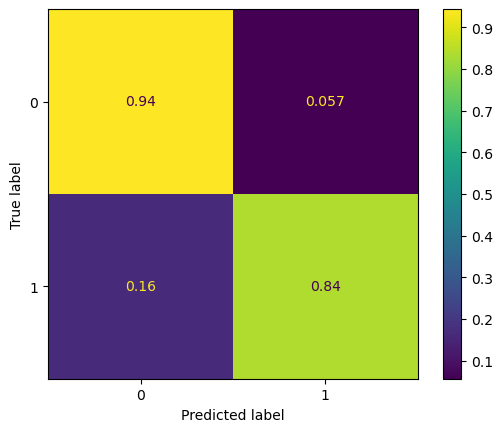

In [83]:
con_mat(baseline_model, test_images, test_labels)

In [ ]:
loss = round(baseline_score[0],4)
recall = round(baseline_score[2],4)
AUC = round(baseline_score[1],4)
name = 'baseline'
df = pd.DataFrame([[loss,recall,AUC]],columns=['loss','recall','AUC'],index=[name])
display(df)

In [ ]:
overfit_model = load_model('saved_models 2/model_8.keras')
overfit_score = overfit_model.evaluate(test_ds)
print(overfit_model)

In [ ]:
final_model = load_model('saved_models 2/final_model.keras')
final_score = final_model.evaluate(test_ds)
print(final_model)

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

NOTES: maybe split betwen bacteria or virus, gather more data obv